### Import the libraries and data

In [227]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
data = pd.read_csv('results.csv')
data.head()

,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup
0,1871-03-27,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,False
1,1872-02-05,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,False
2,1873-03-03,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,False
3,1874-02-23,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,False
4,1875-02-15,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,False


### Pre-process the data to look only at non-neutral, non-world cup games starting from 2015 (arbitrary) onwards. 
- I create the score_diff variable as the difference between the home team score and the away team score
- The home_game and away_game variables come in handy later when finding the averages

In [222]:
df = data[(data['neutral'] == False) \
          & (data['world_cup'] == False) \
          & (data['date'] >= '2015-01-01')
          ].drop(columns=['competition', 'stadium', 'city', 'country', 'neutral', 'world_cup'])
df['score_diff'] = df['home_score']-df['away_score']
df['home_win'] = df.apply(lambda x: 1 if x['home_score'] > x['away_score'] else 0, axis = 1)
df['home_game'] = 1
df['away_game'] = 1
df = df.reset_index(drop=True)
df

,date,home_team,away_team,home_score,away_score,score_diff,home_win,home_game,away_game
0,2015-02-06,Wales,England,16,21,-5,0,1,1
1,2015-02-07,Italy,Ireland,3,26,-23,0,1,1
2,2015-02-07,France,Scotland,15,8,7,1,1,1
3,2015-02-14,Ireland,France,18,11,7,1,1,1
4,2015-02-14,England,Italy,47,17,30,1,1,1
...,...,...,...,...,...,...,...,...,...
373,2023-08-12,England,Wales,19,17,2,1,1,1
374,2023-08-12,France,Scotland,30,27,3,1,1,1
375,2023-08-19,Wales,South Africa,16,52,-36,0,1,1
376,2023-08-19,Ireland,England,29,10,19,1,1,1


### The plot of how the score_diff changes over time. We see that other than the initial portion, the cumulative score difference tends to remain highly positive indicating that there is some benefit to being the home team. 

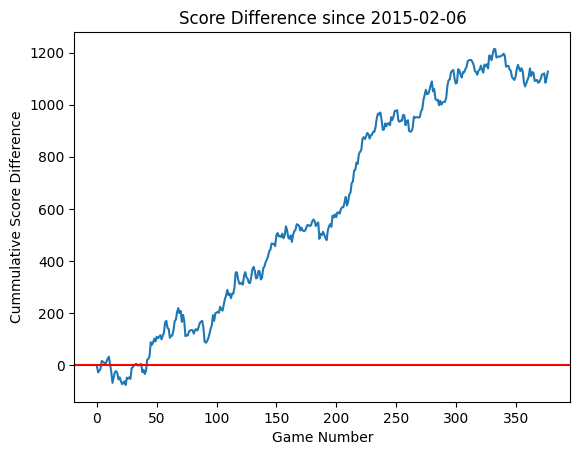

In [223]:
plt.plot(np.cumsum(df['score_diff']))
plt.xlabel('Game Number')
plt.ylabel('Cummulative Score Difference')
plt.title('Score Difference since ' + df['date'][0])
plt.axhline(y = 0, color = 'r', linestyle = '-') 
plt.show()

### We now look at how each combination of home and away teams look in terms of if there are any games which are extremely one sided. I have commented out the portion where I only look at "Tier 1" teams but that is also a useful metric

In [229]:
# agg = df[df['away_team'].isin(['Australia', 'England', 'Ireland', 'New Zealand', 'South Africa', 'Scotland']) & \
#         df['home_team'].isin(['Australia', 'England', 'Ireland', 'New Zealand', 'South Africa', 'Scotland'])]
agg = df
agg = agg.groupby(by = ['home_team', 'away_team']).sum()
agg['ave_diff'] = round(agg['score_diff']/agg['home_game'], 2)
agg['home_win_%'] = round(100*agg['home_win']/agg['home_game'], 2)
agg = agg.drop(columns= ['home_game','away_game'])
agg.sort_values(by = ['ave_diff', 'home_win_%'], ascending=False)

home_score  away_score  score_diff  home_win  \
home_team   away_team                                                   
Ireland     Italy               283          84         199         6   
New Zealand France              127          38          89         3   
England     Italy               249          78         171         6   
New Zealand Wales               121          49          72         3   
Wales       Italy               229          87         142         5   
...                             ...         ...         ...       ...   
Italy       Wales                66         197        -131         0   
            Ireland              59         197        -138         0   
Wales       New Zealand          57         142         -85         0   
Italy       England              29         153        -124         0   
            New Zealand          22         181        -159         0   

                         ave_diff  home_win_%  
home_team   away_team                          
Ireland     Italy           33.17      100.00  
New Zealand France          29.67      100.00  
England     Italy           28.50      100.00  
New Zealand Wales           24.00      100.00  
Wales       Italy           23.67       83.33  
...                           ...         ...  
Italy       Wales          -26.20        0.00  
            Ireland        -27.60        0.00  
Wales       New Zealand    -28.33        0.00  
Italy       England        -31.00        0.00  
            New Zealand    -53.00        0.00  

[83 rows x 6 columns]

### We conduct a 95% Confidence Interval for the score difference. From our results, we see that we are 95% confident that the true score difference lies between our interval. Hence, we are quite confident that there is some home-team advantage. 

In [230]:
int = st.t.interval(alpha=0.95, df=len(df)-1, loc=np.mean(df['score_diff']))
print(round(int[0], 3), round(int[1], 3))

1.015 4.948


### Attempt to create a linear regression for the score difference with various teams when home and away. We also note here that we have a positive intercept, hence indicated that there is a positive outcome for the home team. 
- Teams with negative home_team/positive away_team coefficients do worse in the respective situations


In [226]:
X = df[['home_team', 'away_team']]
X = pd.get_dummies(X)
Y = df[['score_diff']]
sm.OLS(Y, sm.add_constant(X)).fit().summary()

# X_train, X_test, Y_train, Y_test = train_test_split( 
#     X, Y, test_size=0.2, random_state=42) 

# model = LinearRegression().fit(X = X_train, y = Y_train)
# comp_mod = Y_test.reset_index(drop = True).join(pd.DataFrame(model.predict(X_test))).rename(columns = {'0':'predicted'})
# model.coef_

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             score_diff   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     22.31
Date:                Tue, 31 Oct 2023   Prob (F-statistic):           6.02e-48
Time:                        16:57:53   Log-Likelihood:                -1505.8
No. Observations:                 378   AIC:                             3050.
Df Residuals:                     359   BIC:                             3124.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.4899      0.582      4.276      0.000       1.345       3.635
home_team_Argentina      -11.3892      2.425     -4.697      0.000     -16.158      -6.621
home_team_Australia       -0.2343      2.071     -0.113      0.910      -4.307       3.839
home_team_England          5.7519      1.945      2.958      0.003       1.928       9.576
home_team_France           2.9954      2.059      1.455      0.147      -1.053       7.044
home_team_Ireland          9.2690      2.056      4.509      0.000       5.226      13.312
home_team_Italy          -24.8782      2.165    -11.491      0.000     -29.136     -20.621
home_team_New Zealand     16.7172      2.347      7.122      0.000      12.101      21.334
home_team_Scotland        -0.4923      2.123     -0.232      0.817      -4.668       3.683
home_team_South Africa     6.0863      2.300      2.646      0.008       1.563      10.609
home_team_Wales           -1.3359      1.901     -0.703      0.483      -5.074       2.402
away_team_Argentina        4.4116      2.086      2.115      0.035       0.309       8.515
away_team_Australia        1.9097      2.058      0.928      0.354      -2.138       5.957
away_team_England         -3.8450      2.094     -1.837      0.067      -7.962       0.272
away_team_France           0.5010      2.060      0.243      0.808      -3.550       4.552
away_team_Ireland         -5.0506      2.115     -2.388      0.017      -9.209      -0.892
away_team_Italy           19.3068      2.293      8.419      0.000      14.797      23.817
away_team_New Zealand    -15.2442      2.128     -7.163      0.000     -19.429     -11.059
away_team_Scotland         3.7788      2.205      1.714      0.087      -0.557       8.114
away_team_South Africa    -2.2647      2.080     -1.089      0.277      -6.356       1.827
away_team_Wales           -1.0135      2.102     -0.482      0.630      -5.147       3.120
==============================================================================
Omnibus:                        5.336   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                7.336
Skew:                           0.025   Prob(JB):                       0.0255
Kurtosis:                       3.681   Cond. No.                     4.06e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.76e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""